# Warm-starting quantum optimization

## Introduction

Optimization problems with integer variables or constraints are often hard to solve. For example, the Quadratic Unconstrained Binary Optimization (QUBO) problem, i.e.

\begin{align}
\min_{x\in\{0,1\}^n}x^T\Sigma x + \mu^Tx,
\end{align}

is NP-Hard. Here, $\Sigma$ is an $n\times n$ matrix and $x$ is a vector of $n$ binary variables. Note that we could have added the linear term $\mu$ to the diagonal as $x_i^2=x_i$ for $x_i\in\{0, 1\}$. While QUBOs are hard to solve there exists many ways to relax them to problems that are easier to solve.
For example, if $\Sigma$ is semi-definite positive the QUBO can be relaxed and results in a convex Quadratic Program 

\begin{align}
\min_{x\in[0,1]^n}x^T\Sigma x,
\end{align}

which becomes easy to solve as $x$ now represents $n$ continuous variables bound to the range $[0, 1]$.
Such relaxations can be leveraged to warm-start quantum optimization algorithms as shown in [1].

## References

[1] [D. J. Egger, J Marecek, S. Woerner, *Warm-starting quantum optimization*, arXiv:2009.10095](http://arxiv.org/abs/2009.10095)

In [385]:
from typing import List, Tuple
from enum import Enum
import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer, SolutionSample, OptimizationResultStatus
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram

## Preliminaries: relaxing QUBOs

First, we show how to relax a QUBO built with a semi-definite positive matrix to obtain an easy-to-solve QP.

In [386]:
def create_problem(mu: np.array, sigma: np.array, total: int = 3) -> QuadraticProgram:
    """ Solve the quadratic program using docplex. """
    
    mdl = Model()
    x = [mdl.binary_var('x%s' % i) for i in range(len(sigma))]
    
    objective = mdl.sum([mu[i]*x[i] for i in range(len(mu))])
    objective -= 2*mdl.sum([sigma[i, j]*x[i]*x[j] for i in range(len(mu)) for j in range(len(mu))])
    mdl.maximize(objective)
    cost = mdl.sum(x)
    mdl.add_constraint(cost == total)
    
    qp = QuadraticProgram()
    qp.from_docplex(mdl)
    
    return qp

def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

For this example, we use a positive semi-definite matrix $\Sigma$ and a linear term $\mu$ as defined below.

In [387]:
mu = np.array([3.418,  2.0913,  6.2415,  4.4436, 10.892 ,  3.4051])
sigma = np.array([[ 1.07978412,  0.00768914,  0.11227606, -0.06842969, -0.01016793, -0.00839765],
                  [ 0.00768914,  0.10922887, -0.03043424, -0.0020045 ,  0.00670929, 0.0147937 ],
                  [ 0.11227606, -0.03043424,  0.985353  ,  0.02307313, -0.05249785, 0.00904119],
                  [-0.06842969, -0.0020045 ,  0.02307313,  0.6043817 ,  0.03740115, -0.00945322],
                  [-0.01016793,  0.00670929, -0.05249785,  0.03740115,  0.79839634, 0.07616951],
                  [-0.00839765,  0.0147937 ,  0.00904119, -0.00945322,  0.07616951, 1.08464544]])

Using DOCPLEX we build a model with binary variables.

In [388]:
qubo = create_problem(mu, sigma)
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model17

Maximize
 obj: 3.418000000000 x0 + 2.091300000000 x1 + 6.241500000000 x2
      + 4.443600000000 x3 + 10.892000000000 x4 + 3.405100000000 x5 + [
      - 4.319136480000 x0^2 - 0.061513120000 x0*x1 - 0.898208480000 x0*x2
      + 0.547437520000 x0*x3 + 0.081343440000 x0*x4 + 0.067181200000 x0*x5
      - 0.436915480000 x1^2 + 0.243473920000 x1*x2 + 0.016036000000 x1*x3
      - 0.053674320000 x1*x4 - 0.118349600000 x1*x5 - 3.941412000000 x2^2
      - 0.184585040000 x2*x3 + 0.419982800000 x2*x4 - 0.072329520000 x2*x5
      - 2.417526800000 x3^2 - 0.299209200000 x3*x4 + 0.075625760000 x3*x5
      - 3.193585360000 x4^2 - 0.609356080000 x4*x5 - 4.338581760000 x5^2 ]/2
Subject To
 c0: x0 + x1 + x2 + x3 + x4 + x5 = 3

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End

Such binary problems are hard to deal with but can be solved if the problem instance is small enough. Our example above has as solution

In [389]:
CplexOptimizer().solve(qubo)

optimal function value: 16.7689322
optimal value: [0. 0. 1. 1. 1. 0.]
status: SUCCESS

We can create a relaxation of this problem in which the variables are no longer binary. Note that we use the `QuadraticProgramToQubo` converter to convert the constraint into a quadratic penalty term. We do this to remain consistent with the steps that the Qiskit optimization module applies internally. 

In [390]:
qp = relax_problem(QuadraticProgramToQubo().convert(qubo))
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model17

Maximize
 obj: 259.553391640000 x0 + 258.226691640000 x1 + 262.376891640000 x2
      + 260.578991640000 x3 + 267.027391640000 x4 + 259.540491640000 x5 + [
      - 89.697600360000 x0^2 - 170.818440880000 x0*x1 - 171.655136240000 x0*x2
      - 170.209490240000 x0*x3 - 170.675584320000 x0*x4 - 170.689746560000 x0*x5
      - 85.815379360000 x1^2 - 170.513453840000 x1*x2 - 170.740891760000 x1*x3
      - 170.810602080000 x1*x4 - 170.875277360000 x1*x5 - 89.319875880000 x2^2
      - 170.941512800000 x2*x3 - 170.336944960000 x2*x4 - 170.829257280000 x2*x5
      - 87.795990680000 x3^2 - 171.056136960000 x3*x4 - 170.681302000000 x3*x5
      - 88.572049240000 x4^2 - 171.366283840000 x4*x5 - 89.717045640000 x5^2 ]/2
      -384.203087460000
Subject To

Bounds
       x0 <= 1
       x1 <= 1
       x2 <= 1
       x3 <= 1
       x4 <= 1
       x5 <= 1
End

The solution of this continuous relaxation is different from the solution to the binary problem but can be used to warm-start a solver when dealing with the binary problem.

In [391]:
sol = CplexOptimizer().solve(qp)
sol

optimal function value: 17.01205502568274
optimal value: [1.75249958e-01 1.48038882e-07 9.70905326e-01 7.38416868e-01
 9.99999992e-01 1.44389045e-01]
status: SUCCESS

In [392]:
c_stars = sol.samples[0].x
c_stars

[0.17524995761801201,
 1.4803888163984595e-07,
 0.9709053264087679,
 0.7384168677494151,
 0.9999999916475085,
 0.14438904470168346]

## QAOA

Here, we illustrate how to warm-start the quantum approximate optimization algorithm (QAOA) by leveraging the relaxed problem shown above. 

### Standard QAOA

First, we use standard QAOA to solve the QUBO. To do this, we convert the QUBO to Qiskit's QuadraticProgram class (note that the resulting problem is still a binary problem).

In [393]:
algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                   seed_simulator=algorithm_globals.random_seed,
                                   seed_transpiler=algorithm_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
exact_mes = NumPyMinimumEigensolver()

In [394]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [395]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)

optimal function value: 16.768932200000002
optimal value: [0. 0. 1. 1. 1. 0.]
status: SUCCESS


### Warm-start QAOA

Next, we compare this result to a warm-start QAOA in which we use the solution to the continuous relaxation of the problem. First, we create the initial state 

\begin{align}
|\phi^*\rangle=\bigotimes_{i=0}^{n-1}R_y(\theta_i)|0\rangle_n .
\end{align}

which is given by applying $R_y$ rotations with an angle $\theta=2\arcsin(\sqrt{c^*_i})$ that depends on the solution to the relaxed problem.
Here, $c^*_i$ the value of variable $i$ of the relaxed problem.

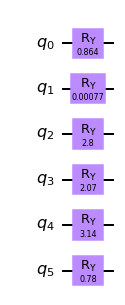

In [396]:
from qiskit import QuantumCircuit

thetas = [2*np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(len(sigma))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)
    
init_qc.draw(output='mpl')

Next, we create the mixer operator for QAOA. When warm-starting QAOA we must ensure that the mixer operator has the initial state as ground state. We therefore chose the Hamiltonian

\begin{align}
H_{M,i}^{(ws)}=
\begin{pmatrix}
2c_i^*-1 & -2\sqrt{c_i^*(1-c_i^*)} \\
-2\sqrt{c_i^*(1-c_i^*)} & 1-2c_i^*
\end{pmatrix}
\end{align}

as mixer operator for qubit $i$. Once multiplied by $-i\beta$ and exponentiated this mixer produces the following mixer circuit.

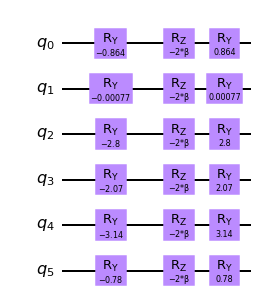

In [397]:
from qiskit.circuit import Parameter

beta = Parameter('β')

ws_mixer = QuantumCircuit(len(sigma))
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2*beta, idx)
    ws_mixer.ry(theta, idx)
    
ws_mixer.draw(output='mpl')

The initial state and mixer operator can then be passed to QAOA.

In [398]:
ws_qaoa_mes = QAOA(quantum_instance=quantum_instance, 
                   initial_state=init_qc, 
                   mixer=ws_mixer,
                   initial_point=[0., 1.])

In [399]:
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

In [400]:
ws_qaoa_result = ws_qaoa.solve(qubo)
print(ws_qaoa_result)

optimal function value: 16.768932200000002
optimal value: [0. 0. 1. 1. 1. 0.]
status: SUCCESS


### Analysis
Objects of type `SolutionSample` (here denoted as *samples*) are a useful information source provided
by `OptimizationResult` objects. They contain information about input values `x`, corresponding (optimized) function
values `fval`, probability of obtaining that result `probability` and the solution status `status` (`SUCCESS`,
`FAILURE`, `INFEASIBLE`).

They can be easily printed out in a better-readable format.

In [401]:
def print_samples(samples: List[SolutionSample],
                  max_len: int = None):
    status_str = {OptimizationResultStatus.SUCCESS: 'SUCCESS',
                  OptimizationResultStatus.FAILURE: 'FAILURE',
                  OptimizationResultStatus.INFEASIBLE: 'INFEASIBLE'}
    print('\n'.join(['[{}]: fval: {:.4f}, probability: {:.2f} [{}]'.format(''.join(str(int(_)) for _ in e.x),
                                                                           e.fval,
                                                                           e.probability,
                                                                           status_str[e.status])
            for e in sorted(samples, key=lambda x: x.probability, reverse=True)][:max_len]))

In [402]:
print_samples(ws_qaoa_result.samples, max_len=10)

[001110]: fval: 16.7689, probability: 0.86 [SUCCESS]
[001010]: fval: 13.7760, probability: 0.07 [INFEASIBLE]
[100110]: fval: 13.9533, probability: 0.02 [SUCCESS]
[001111]: fval: 17.7017, probability: 0.01 [INFEASIBLE]
[000110]: fval: 12.3804, probability: 0.01 [INFEASIBLE]
[101010]: fval: 14.6260, probability: 0.01 [SUCCESS]
[101110]: fval: 17.8927, probability: 0.01 [INFEASIBLE]
[001011]: fval: 14.6710, probability: 0.00 [SUCCESS]
[101111]: fval: 18.8590, probability: 0.00 [INFEASIBLE]
[100010]: fval: 10.5943, probability: 0.00 [INFEASIBLE]


We may also want to filter samples according to their status or to a certain percentile, i.e. with probability higher
than some threshold.

In [403]:
def get_filtered_samples(samples: List[SolutionSample],
                         percentile: float = 0,
                         allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,)):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > percentile:
            res.append(s)

    return res

In [404]:
filtered_samples = get_filtered_samples(ws_qaoa_result.samples,
                                        percentile=0.005,
                                        allowed_status=(OptimizationResultStatus.SUCCESS,))
print_samples(filtered_samples, max_len=10)

[001110]: fval: 16.7689, probability: 0.86 [SUCCESS]
[100110]: fval: 13.9533, probability: 0.02 [SUCCESS]
[101010]: fval: 14.6260, probability: 0.01 [SUCCESS]


If we want to obtain a better perspective of the results, statistics is very helpful, both with respect to
optimized function values and their respective probabilities. Thus, mean and standard deviation are the very basics for
understanding the results.

In [405]:
class PropertyChoice(Enum):
    FVAL = 0
    PROBABILITY = 1


def get_samples_mean(samples: List[SolutionSample],
                     property: PropertyChoice = PropertyChoice.FVAL):
    return np.mean([(e.fval if property is PropertyChoice.FVAL else e.probability) for e in samples])


def get_samples_std(samples: List[SolutionSample],
                    property: PropertyChoice = PropertyChoice.FVAL):
    return np.std([(e.fval if property is PropertyChoice.FVAL else e.probability) for e in samples])

In [406]:
get_samples_mean(ws_qaoa_result.samples, property=PropertyChoice.FVAL)

14.135223479999999

In [407]:
get_samples_std(ws_qaoa_result.samples, property=PropertyChoice.FVAL)

2.7504930010887656

Finally, despite all number-crunching, visualization is usually the best early-analysis approach.

In [408]:
def get_samples_property(samples: List[SolutionSample],
                         property: PropertyChoice = PropertyChoice.PROBABILITY):
    return {''.join(str(int(_)) for _ in s.x): (s.fval if property is PropertyChoice.FVAL else s.probability)
            for s in samples}

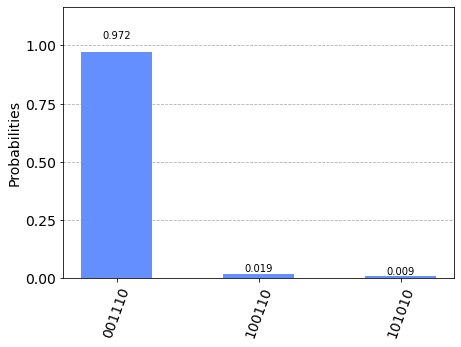

In [409]:
plot_histogram(get_samples_property(filtered_samples))

Now let's get back to the previous section. Both results there appear to give the same result. However, when we look
at the underlying probability distribution we observe that the warm-start QAOA has a much higher probability of
sampling the optimal solution, providing us a good example of an importance of closer analysis.

In [410]:
print_samples(get_filtered_samples(qaoa_result.samples), max_len=10)

[100110]: fval: 13.9533, probability: 0.05 [SUCCESS]
[010011]: fval: 12.0132, probability: 0.04 [SUCCESS]
[101001]: fval: 6.3134, probability: 0.03 [SUCCESS]
[001101]: fval: 8.6508, probability: 0.03 [SUCCESS]
[001110]: fval: 16.7689, probability: 0.03 [SUCCESS]
[110001]: fval: 4.3107, probability: 0.03 [SUCCESS]
[011100]: fval: 9.4159, probability: 0.02 [SUCCESS]
[010110]: fval: 14.2345, probability: 0.02 [SUCCESS]
[001011]: fval: 14.6710, probability: 0.02 [SUCCESS]
[101010]: fval: 14.6260, probability: 0.02 [SUCCESS]


In [411]:
print_samples(get_filtered_samples(ws_qaoa_result.samples))

[001110]: fval: 16.7689, probability: 0.86 [SUCCESS]
[100110]: fval: 13.9533, probability: 0.02 [SUCCESS]
[101010]: fval: 14.6260, probability: 0.01 [SUCCESS]
[001011]: fval: 14.6710, probability: 0.00 [SUCCESS]
[000111]: fval: 13.3494, probability: 0.00 [SUCCESS]
[100011]: fval: 11.5590, probability: 0.00 [SUCCESS]


## Warm-start QAOA

The warm-start features above are available in the Qiskit optimization module as a single optimizer named `WarmStartQAOAOptimizer` which is illustrated below. This solver will solve a QUBO with a warm-start QAOA. It computes $c^*$ by relaxing the problem. This behavior is controlled by setting `relax_for_pre_solver` to `True`.

In [412]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

In [413]:
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, 
                                 qaoa=qaoa_mes, epsilon=0.0)

In [414]:
ws_result = ws_qaoa.solve(qubo)
ws_result

optimal function value: 16.768932200000002
optimal value: [0. 0. 1. 1. 1. 0.]
status: SUCCESS

In [415]:
print_samples(ws_result.samples)

[001110]: fval: 16.7689, probability: 0.86 [SUCCESS]
[001010]: fval: 13.7760, probability: 0.07 [INFEASIBLE]
[100110]: fval: 13.9533, probability: 0.02 [SUCCESS]
[001111]: fval: 17.7017, probability: 0.01 [INFEASIBLE]
[000110]: fval: 12.3804, probability: 0.01 [INFEASIBLE]
[101010]: fval: 14.6260, probability: 0.01 [SUCCESS]
[101110]: fval: 17.8927, probability: 0.01 [INFEASIBLE]
[001011]: fval: 14.6710, probability: 0.00 [SUCCESS]
[101111]: fval: 18.8590, probability: 0.00 [INFEASIBLE]
[100010]: fval: 10.5943, probability: 0.00 [INFEASIBLE]
[000111]: fval: 13.3494, probability: 0.00 [SUCCESS]
[000010]: fval: 9.2952, probability: 0.00 [INFEASIBLE]
[000011]: fval: 10.2263, probability: 0.00 [INFEASIBLE]
[101011]: fval: 15.5545, probability: 0.00 [INFEASIBLE]
[100011]: fval: 11.5590, probability: 0.00 [SUCCESS]
[100111]: fval: 14.9558, probability: 0.00 [INFEASIBLE]


In [416]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

ImportError: These functions  need ipywidgets. Run "pip install ipywidgets" before.